# HDD dataset creation 4 - Quarters from the downloaded dataset.

Original Dataset is downloaded from the BackBlaze, refer the download script (download_dataset.sh). Since the dataset for 4Q are approx 11Gb in size, we have to create the dataset with the devices which are failing over the period of time.
original dataset is expected to be unbalanced in nature as data is collected from ~2.7L devices and approx 4K failures were observed as part of the dataset cleaning and EDA.

We will be creating a working dataset which consist of serial numbers of the failing devices.

Note: Since the dataset is huge we would be using the Python Dask library for cleaning of the data for intial processing

# Section Python Library and Dataset load for further processing

## Python Library and functions import section

In [1]:
import dask.dataframe as dd
import pandas as pd

import matplotlib.pyplot as plt

## Load dataset to Dask, identify its shape and types.

In [2]:
ddf = dd.read_csv("/nobackup/amimalik/bits/dataset/data/*.csv", assume_missing=True)

In [3]:
# Check the columns of the dataset
ddf.dtypes

date                    string[pyarrow]
serial_number           string[pyarrow]
model                   string[pyarrow]
capacity_bytes                  float64
failure                         float64
                             ...       
smart_252_raw                   float64
smart_254_normalized            float64
smart_254_raw                   float64
smart_255_normalized            float64
smart_255_raw                   float64
Length: 186, dtype: object

## EDA - Identify the trend of Device models failure observed in original dataset

In [4]:
# Identify the failed device counts by model
failure_counts = ddf.groupby("model")["failure"].sum().compute()

# Sort by failures in descending order
sorted_failures = failure_counts.sort_values(ascending=False)

In [5]:
# Print the sorted table
sorted_failures.head(10)

model
ST12000NM0008           597.0
ST8000NM0055            490.0
ST4000DM000             453.0
TOSHIBA MG07ACA14TA     418.0
HGST HUH721212ALN604    403.0
ST8000DM002             254.0
TOSHIBA MG08ACA16TA     227.0
ST14000NM001G           199.0
ST16000NM001G           195.0
ST12000NM001G           169.0
Name: failure, dtype: float64

In [6]:
# Saving the sorted serial numbers to a CSV file for later use, reference or sharing
sorted_failures.to_csv("/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv")

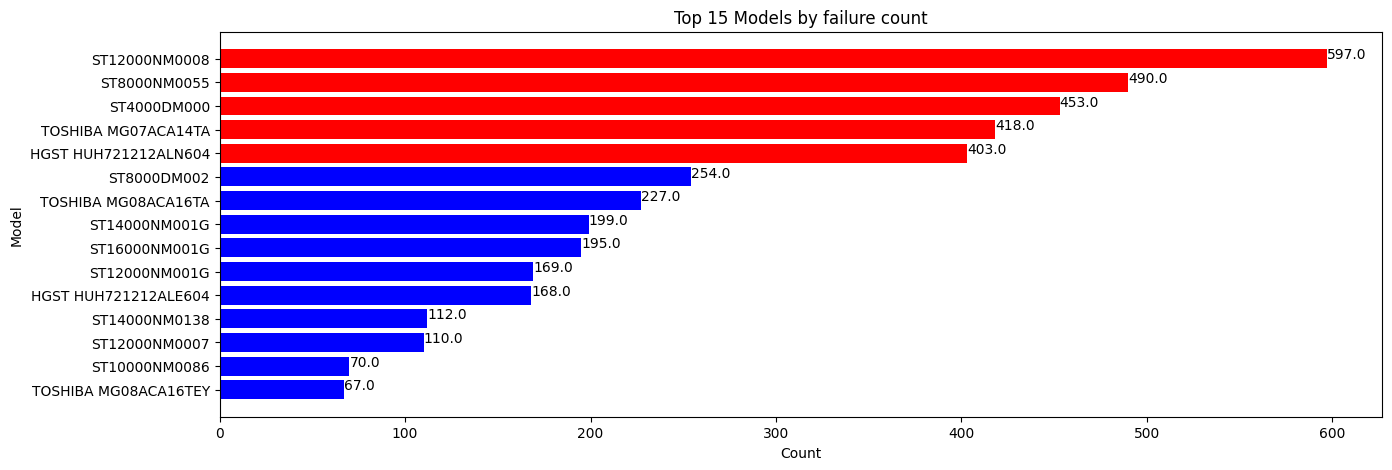

In [7]:
## Plotting the top 15 model vs failure count graph

fig = plt.figure(figsize=(15, 5))

# Get the top 5 models by count
top_5_models = sorted_failures.head(5)
top_15_models = sorted_failures.head(15)

top_15_models.to_csv("/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv")

# Set the color for the top 5 models as red and the rest as blue
colors = ['red' if model in top_5_models else 'blue' for model in top_15_models.index]

# Plot the horizontal bar graph
plt.barh(top_15_models.index, top_15_models.values, color=colors)

# Set the title and labels
plt.title('Top 15 Models by failure count')
plt.xlabel('Count')
plt.ylabel('Model')

plt.gca().invert_yaxis()

for index, value in enumerate(top_15_models.values):
    plt.text(value, index, str(value))

# Show the plot
plt.show()

We will be using the device model "ST12000NM0008" for slecting the failed drive dataset creation

## Generate the Dataset containing only failed devices 

In [8]:
# Filter DataFrame to rows where failure is observed
failed_devices = ddf[ddf["failure"] == 1]

In [9]:
# Filter DataFrame to rows where failure is observed
failed_devices = ddf[ddf["failure"] == 1]
failed_serials = failed_devices["serial_number"]
failed_serials = failed_serials.unique().compute()

In [10]:
failed_serials.shape[0]

4406

In [11]:
failed_serials.head()

0        2AGM8N2Y
1        ZHZ3RTRK
2        ZLW17WGQ
3        ZHZ306JY
4    31C0A00AF9RG
Name: serial_number, dtype: object

In [12]:
# Create a DataFrame with only the failed devices with all features from original dataframe.

failed_devices_df = ddf[ddf["serial_number"].isin(failed_serials)]
failed_devices_df = failed_devices_df.compute()

In [13]:
# Convert the data type of the date column to datetime
failed_devices_df['date'] = dd.to_datetime(failed_devices_df['date'], format='%Y-%m-%d')  # Adjust the format as needed

failed_devices_df.dtypes

date                   datetime64[ns]
serial_number                  object
model                          object
capacity_bytes                float64
failure                       float64
                            ...      
pod_slot_num                  float64
smart_27_normalized           float64
smart_27_raw                  float64
smart_82_normalized           float64
smart_82_raw                  float64
Length: 193, dtype: object

In [14]:
failed_devices_df.head()

,date,serial_number,model,capacity_bytes,failure,vault_id,pod_id,is_legacy_format,smart_1_normalized,smart_1_raw,...,smart_254_raw,smart_255_normalized,smart_255_raw,datacenter,cluster_id,pod_slot_num,smart_27_normalized,smart_27_raw,smart_82_normalized,smart_82_raw
750,2023-04-13,W300R8BM,ST4000DM000,4.000787e+12,0.0,1000.0,16.0,False,108.0,17541336.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,2023-04-16,Z302BN64,ST4000DM000,4.000787e+12,0.0,1001.0,1.0,False,120.0,237505480.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1052,2023-10-14,Z302A194,ST4000DM000,4.000787e+12,0.0,1001.0,2.0,False,103.0,6161904.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,2023-04-16,Z302ALE1,ST4000DM000,4.000787e+12,0.0,1001.0,4.0,False,114.0,64195984.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1142,2023-10-17,Z302B0W7,ST4000DM000,4.000787e+12,0.0,1001.0,4.0,False,118.0,196318216.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
failed_devices_df.to_parquet("/nobackup/amimalik/bits/dataset/dimensions/4Q/failed_devices_df_all.parquet")